## Super resolution

In [1]:
from fastai.vision.all import *

In [2]:
path = Path('/home/lleonard/Documents/datasets/danbooru/0/danbooru2020/')
path_hr = path/'512px'
path_lr = path/'96px'
path_mr = path/'256px'

In [3]:
bs,size=32,128
arch = resnet34

In [4]:
def short_id(full_id):
    return str(int(full_id) % 1000).zfill(4)

def short_id_from_filename(filename):
    return short_id(int(filename.name[:-4]))

def get_y(x):
    parent_folder = short_id_from_filename(x)
    return path_hr / parent_folder / x.name

def get_subset_images(start_folder, end_folder):
    def f(path):
        return [f for f in get_image_files(path) if short_id_from_filename(f) <=end_folder and short_id_from_filename(f) >= start_folder]
    return f

def get_dls(bs,size):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_subset_images('0000','0001'),
                   get_y=get_y,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.), Normalize()])
    dls = dblock.dataloaders(path_lr, bs=bs, path=path, item_tfms=Resize(size))         
    dls.c = 3
    return dls

In [5]:
dls = get_dls(bs,size)

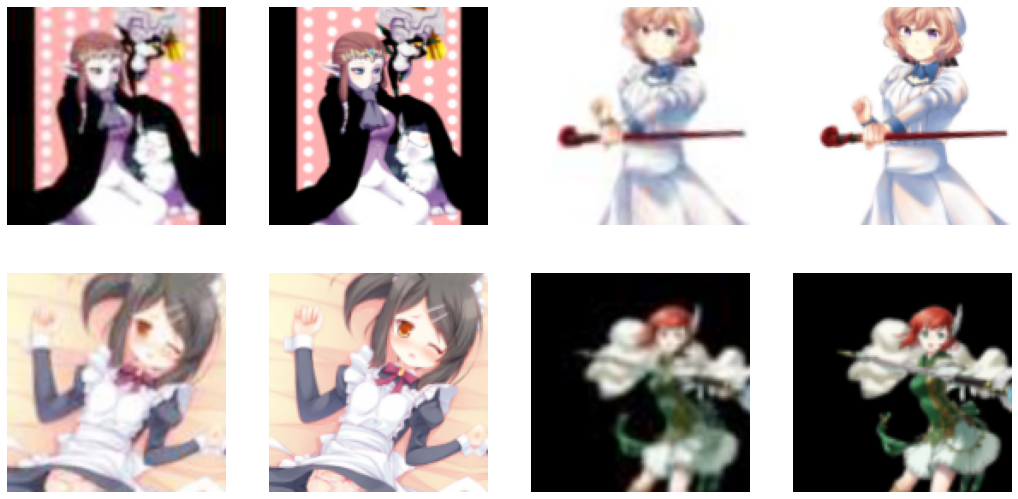

In [6]:
dls.train.show_batch(max_n=4, figsize=(18,9))

## MSE loss

In [7]:
base_loss = F.mse_loss

## Train

In [8]:
learn = unet_learner(dls, arch, loss_func=base_loss,
                     blur=True, norm_type=NormType.Weight)

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0003981071640737355)

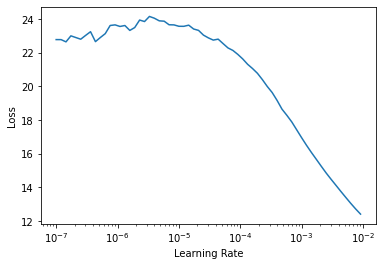

In [9]:
learn.lr_find()

In [10]:
lr = 9e-4
wd = 1e-3

In [12]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start, wd=wd)
    learn.save(save_name)
    learn.show_results(max_n=2, figsize=(15,11))

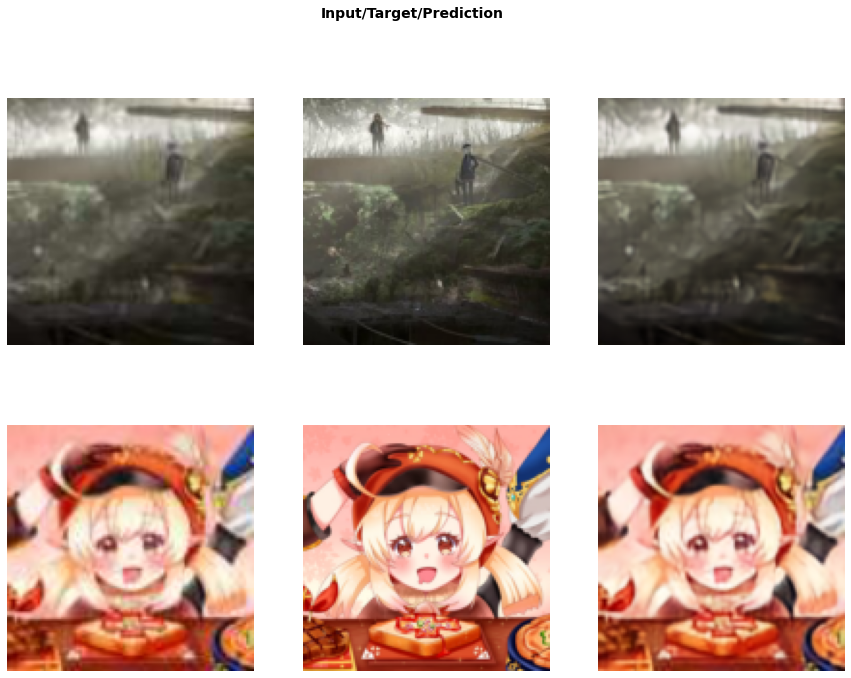

In [13]:
do_fit('super_res/simple_mse_1a', slice(lr*10))

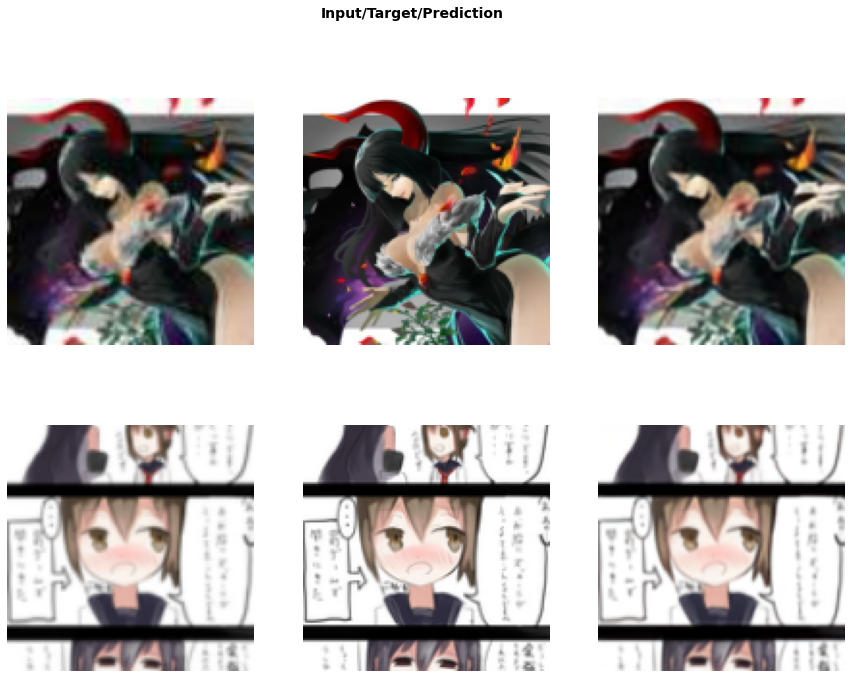

In [13]:
learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

In [14]:
learn.unfreeze()

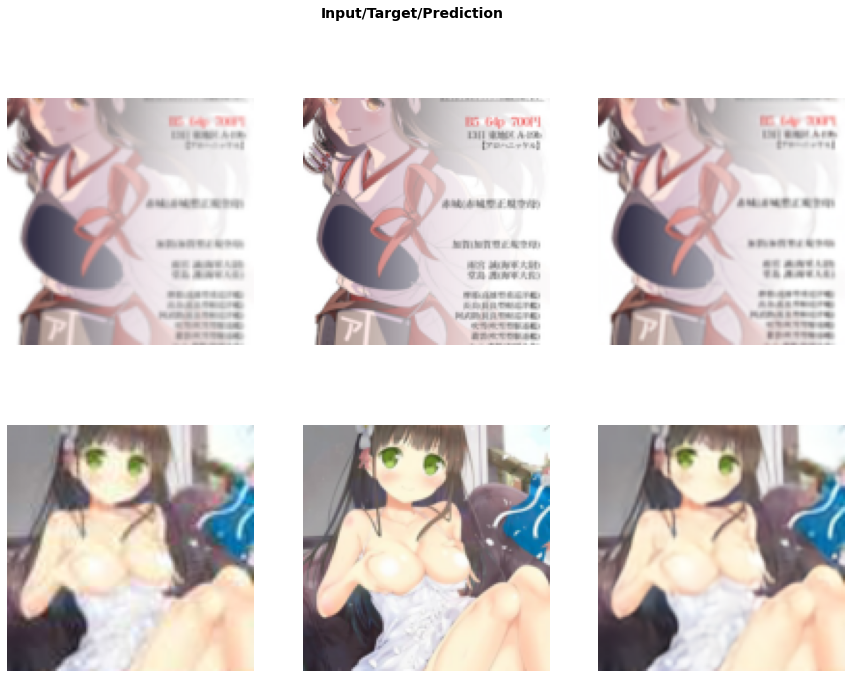

In [15]:
do_fit('super_res/simple_mse_1b', slice(1e-5,lr))

In [16]:
dls = get_dls(12,size*2)

In [17]:
learn.dls = dls
learn.freeze()

In [18]:
# learn.load('super_res/simple_mse_1b');

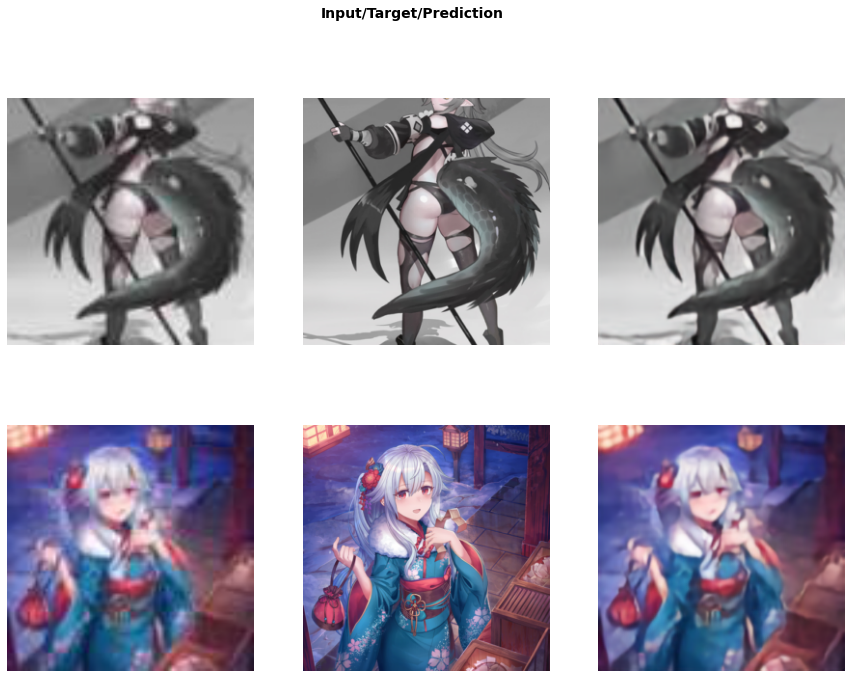

In [18]:
do_fit('super_res/simple_mse_2a')

In [20]:
learn.unfreeze()

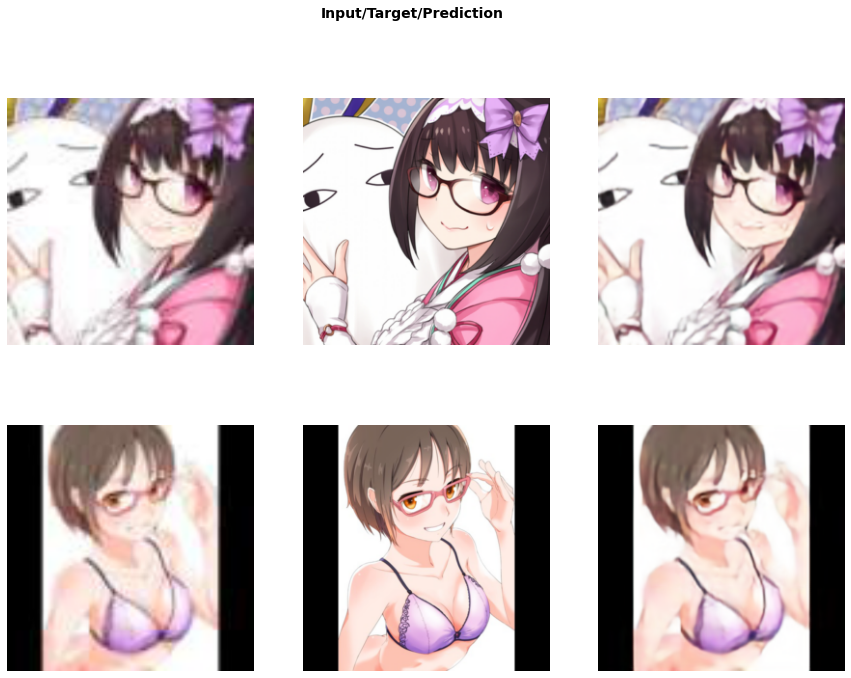

In [21]:
do_fit('super_res/simple_mse_2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [25]:
loaded_learn = unet_learner(dls, arch, loss_func=base_loss,
                     blur=True, norm_type=NormType.Weight)

In [26]:
loaded_learn.load('super_res/simple_mse_2b');

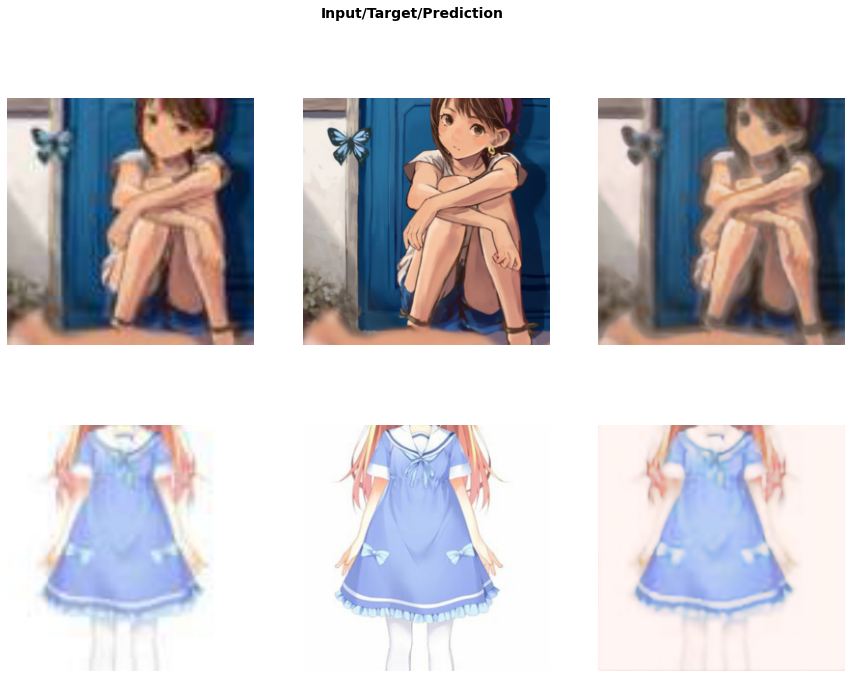

In [27]:
loaded_learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 364)
(512, 512)
torch.Size([3, 512, 512])


<AxesSubplot:>

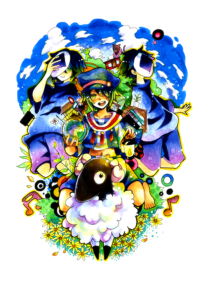

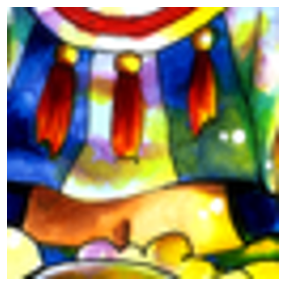

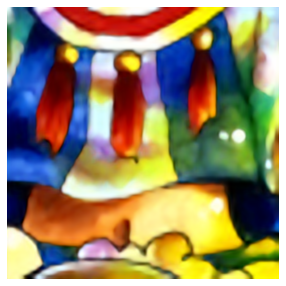

In [24]:
import glob
import torchvision.transforms as T
ratings = pd.read_csv('../data/clean_0000.csv')
image_id = ratings[ratings['rating'] == 's'].sample(1).values[0][0]

id = short_id(image_id)

image = PILImage.create(glob.glob(str(path_hr / id / str(image_id)) + '.*')[0])
show_image(image)
print(image.shape)

part_size = 64
w, h = image.size
image = image.crop((w/2-(part_size / 2), h/2-(part_size / 2),w/2+(part_size / 2), h/2+(part_size / 2))).resize((512,512))

#convert to fastai image type
image = PILImage.create(np.array(image.convert('RGB')))

show_image(image.resize((256,256), Image.LANCZOS))
print(image.shape)


img_hr,*_ = learn.model(ToTensor()(image).unsqueeze(0).float().cuda() / 255.)
print(img_hr.shape)
show_image(img_hr)

In [26]:
torch.save({'model': learn.model}, './super_res_mse.pth')